# Aim 

The aim of this code is to:

1. Perform more EDA in the form of clustering. We will be using Kmodes
3. Model some of the data and hopefully validate assumptions


In [1]:
#import the relavant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from kmodes.kmodes import KModes
from kmodes import kmodes

In [2]:
# Read the data file and take a look at the data
local_folder = '.'
df = pd.read_sas(os.path.join(local_folder, 'hints5_cycle3_public.sas7bdat'),encoding='mac_roman')

#display all columns and the first couple of rows
pd.set_option('display.max_columns', None)
df.head(15);

In [3]:
df.info;

In [4]:
df['Age_groups'] = pd.cut(df['Age'], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['10-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

Survey responses are prone to missing data in the form of non-responses and/or indeterminate data. In the HINTS data set, the missing information is identified using the following values:

**-1**: Valid skips or appropriately missing data following a dependent question (correctly skipped)

**-2**: The question was answered in error by the respondent

**-4**: unreadable or non-conforming numeric response)

**-5**: Respondent selected more response options than appropriate for the question

**-6**: Missing data in variables following a missing filter question

**-7**: Missing data (exclusive to web mode respondent variables)

**-9**: Missing data. Not ascertained

We need to figure out if the missing data is randomly missing or not. We can do this by visual inspect as done below for the Age variable


In [5]:
#Visually inspect the Age missing data
df.loc[df.Age == -9.0,:].head(60);

It appears the missing Age data is randomly missing. A similar inspections on other variables of interest yields similar results.
Suppose for interest's sake that we remove the rows with missing Age data (this includes rows with -9, -7 and -4 values). The result dataframe will be as follows

In [6]:
#replace missing data with NaN, remove Age values with NaN
df['Age'].replace([-9.0,-4.0,-7.0], np.nan, inplace = True)

drop_df=df.dropna(subset=["Age"])

The dataset contains a lot of missing data that falls under these sections:


**1**: Responses about looking for health information

**2**: Responses about using the internet to find information

**3**: Responses about the respondent's health care

**4**: Responses about the respondent's medical records etc.

Later on, we will have to deal with these missing values


In [7]:
#Below we select some variables of interest
age =['Age','Age_groups']
hlth_info = ['SeekHealthInfo']
electronic_info = ['UseInternet','Electronic_SelfHealthInfo','Electronic_BuyMedicine','Electronic_TalkDoctor',\
                   'Electronic_TrackedHealthCosts','Electronic_TestResults','Electronic_MadeAppts', \
                   'HaveDevice_Cat', 'TabletHealthWellnessApps', 'Tablet_AchieveGoal','Tablet_MakeDecision','AccessUsingHealthApp']
med_records = ['AccessUsingHealthApp','UnderstandOnlineMedRec','UsefulOnlineMedRec']

In [8]:
#convert missing data to NaN
#df['SeekHealthInfo'].replace(-9.0, np.nan, inplace = True)
#df['UseInternet'].replace(-9.0, np.nan, inplace = True)
#df['Electronic_SelfHealthInfo'].replace(-9.0, np.nan, inplace = True)
#df['Electronic_BuyMedicine'].replace(-9.0, np.nan, inplace = True)
#df['Electronic_TalkDoctor'].replace(-9.0, np.nan, inplace = True)
#df['Electronic_TrackedHealthCosts'].replace(-9.0, np.nan, inplace = True)
#df['Electronic_MadeAppts'].replace(-9.0, np.nan, inplace = True)

## KModes Clustering

In the following section we perform the clustering for **ALL AGES**. This kmode method was inspired by an example found at the link given here https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering We select the variables of interest and run the model 

In [9]:
#selecting values of interest, in this case it is the columns with internet usage data
electronic_df = drop_df[electronic_info]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 27653.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 602, cost: 20495.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1194, cost: 18577.0
Run 1, iteration: 2/100, moves: 578, cost: 17599.0
Run 1, iteration: 3/100, moves: 126, cost: 17599.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1132, cost: 16816.0


Text(0.5,0,'Number of Clusters (k)')

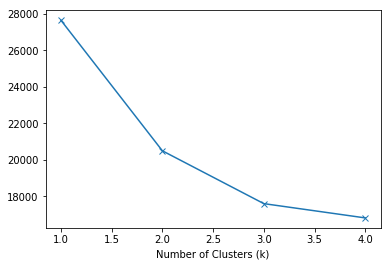

In [10]:
#Find the best number of clusters for applying this model using the elbow method
cost = []
K_range = range(1, 5)

for k_num in K_range:
    modes = KModes(n_clusters=k_num, init = "Cao", n_init = 1, verbose=1)
    modes.fit_predict(electronic_df.astype(str))
    cost.append(modes.cost_)
    
y = np.array([i for i in range(1,5,1)])
plt.plot(K_range,cost, marker='x')
plt.xlabel('Number of Clusters (k)')

We select k = 3 based on the graph plotted above

In [11]:
#run the model 
cao_k1 = KModes(n_clusters=3, init = "Cao", n_init = 1, verbose=1)
run_model = cao_k1.fit_predict(electronic_df.astype(str))

# this is the dataframe with the 3 different clusters
clusters1 = pd.DataFrame(run_model)
clusters1.columns = ['clusters']

#this is the dataframe with the centroid values for each cluster
centroid_df1 = pd.DataFrame(cao_k1.cluster_centroids_)
centroid_df1.columns = electronic_df.columns

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1194, cost: 18577.0
Run 1, iteration: 2/100, moves: 578, cost: 17599.0
Run 1, iteration: 3/100, moves: 126, cost: 17599.0


In [12]:
#concatenate the original dataset with the cluster dataset to link the clusters with the survey respondents
final_df = pd.concat([df[age + electronic_info], clusters1], axis = 1).reset_index()

final_df

,index,Age,Age_groups,UseInternet,Electronic_SelfHealthInfo,Electronic_BuyMedicine,Electronic_TalkDoctor,Electronic_TrackedHealthCosts,Electronic_TestResults,Electronic_MadeAppts,HaveDevice_Cat,TabletHealthWellnessApps,Tablet_AchieveGoal,Tablet_MakeDecision,AccessUsingHealthApp,clusters
0,0,71.0,70-80,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,-1.0,-1.0,-1.0,-9.0,2.0
1,1,47.0,40-50,1.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,-2.0,0.0
2,2,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0
3,3,65.0,60-70,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,-2.0,-1.0,-1.0,-1.0,0.0
4,4,45.0,40-50,1.0,1.0,2.0,2.0,2.0,-9.0,2.0,5.0,2.0,2.0,1.0,-2.0,2.0
5,5,70.0,60-70,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,-1.0,-2.0,-2.0,-2.0,0.0
6,6,53.0,50-60,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,-1.0,2.0
7,7,80.0,70-80,2.0,2.0,2.0,2.0,2.0,-9.0,2.0,3.0,-1.0,-1.0,-1.0,-2.0,1.0
8,8,NaN,NaN,2.0,2.0,-9.0,-9.0,1.0,2.0,2.0,3.0,-2.0,-2.0,-2.0,-9.0,2.0
9,9,23.0,20-30,1.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,0.0


In [13]:
final_df = final_df.drop(['index'], axis = 1)

clust1 = final_df[final_df['clusters'] == 0]
clust2 = final_df[final_df['clusters'] == 1]
clust3 = final_df[final_df['clusters'] == 2]

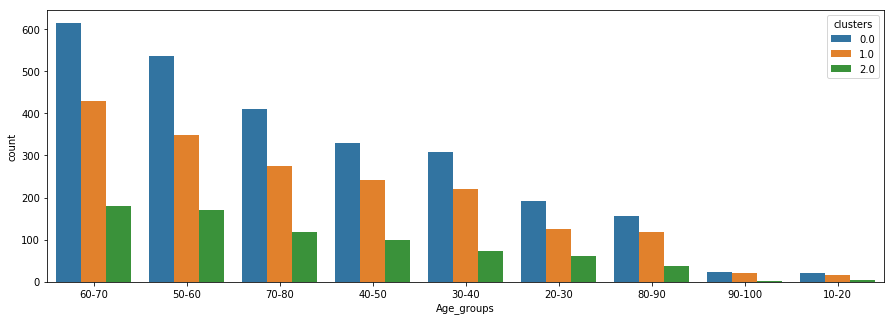

In [14]:
#plot the resulting graph
plt.subplots(figsize = (15,5))
sns.countplot(x=final_df['Age_groups'],order=final_df['Age_groups'].value_counts().index,hue=final_df['clusters'])
plt.show()

In [15]:
#display the centroids to decipher what each cluster
centroid_df1

,UseInternet,Electronic_SelfHealthInfo,Electronic_BuyMedicine,Electronic_TalkDoctor,Electronic_TrackedHealthCosts,Electronic_TestResults,Electronic_MadeAppts,HaveDevice_Cat,TabletHealthWellnessApps,Tablet_AchieveGoal,Tablet_MakeDecision,AccessUsingHealthApp
0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,-1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,-1.0,-1.0,-1.0,-2.0


From the results we see that there is a good clustering of 50+ year olds at centroid 0. This centroid represents those who answered "yes" to using the internet and using it for searching for health info, but do not use it for activities such as buying medicine, talking to doctors, tracking health costs etc. This group have multiple devices i.e at least a tablet or smartphone, but they do not use health or wellness apps.

In this next section we do the same exercise for just the **65+ year old** adult population. 

In [16]:
#filter data to get only 65+ year olds' responses
elderly_df = drop_df[drop_df['Age']>=65]

In [17]:
## In this instance, we would like to begin investigating the how this agegroup interacts with online resources. some of the responses
## we look at are whether they access medical records using apps, understand health information in their online medical records and
## if they find monitoring medical records online useful at all


## we select the variables of interest
#electronic_eld_df = elderly_df[electronic_info]
med_eld_df = elderly_df[med_records]
#med_eld_df2 = med_eld_df[(med_eld_df['AccessUsingHealthApp']>0)&(med_eld_df['UnderstandOnlineMedRec']>0)&(med_eld_df['UsefulOnlineMedRec']>0)]

med_eld_df;

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 3389.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 2489.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 1432.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4, cost: 1431.0


Text(0.5,0,'Number of Clusters (k)')

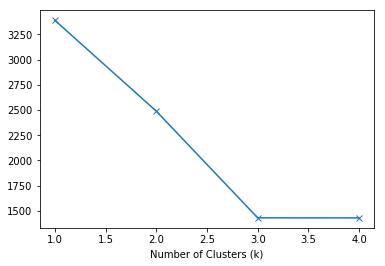

In [18]:
#Find the best k
cost = []
K_range = range(1, 5)

for k_num in K_range:
    modes = KModes(n_clusters=k_num, init = "Cao", n_init = 1, verbose=1)
    modes.fit_predict(med_eld_df.astype(str))
    cost.append(modes.cost_)
    
y = np.array([i for i in range(1,5,1)])
plt.plot(K_range,cost, marker='x')
plt.xlabel('Number of Clusters (k)')


In [19]:
# wedetermined that the best k = 3 in this instance again; now we run the model
cao_k2 = KModes(n_clusters=3, init = "Cao", n_init = 1, verbose=1)
#run_model2 = cao_k2.fit_predict(electronic_eld_df.astype(str))
run_model2 = cao_k2.fit_predict(med_eld_df.astype(str))


#this is the dataset of the clusters
clusters2 = pd.DataFrame(run_model2)
clusters2.columns = ['clusters']

#this is the dataset of the centroids
centroid_df2 = pd.DataFrame(cao_k2.cluster_centroids_)
#centroid_df2.columns = electronic_eld_df.columns
centroid_df2.columns = med_eld_df.columns


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5, cost: 1432.0


In [20]:
#index = med_eld_df[(med_eld_df['AccessUsingHealthApp']>0)&(med_eld_df['UnderstandOnlineMedRec']>0)&(med_eld_df['UsefulOnlineMedRec']>0)].index

In [21]:
#med_eld_age_df = elderly_df[age].loc[index]
#med_eld_age_df

In [26]:
#final_df2 = pd.concat([elderly_df[age + electronic_info], clusters2], axis = 1).reset_index()
final_df2 = pd.concat([elderly_df[age + med_records],clusters2],axis = 1).reset_index()
final_df2;

In [23]:
final_df2 = final_df2.drop(['index'], axis = 1)

clust1 = final_df2[final_df2['clusters'] == 0]
clust2 = final_df2[final_df2['clusters'] == 1]
clust3 = final_df2[final_df2['clusters'] == 2]

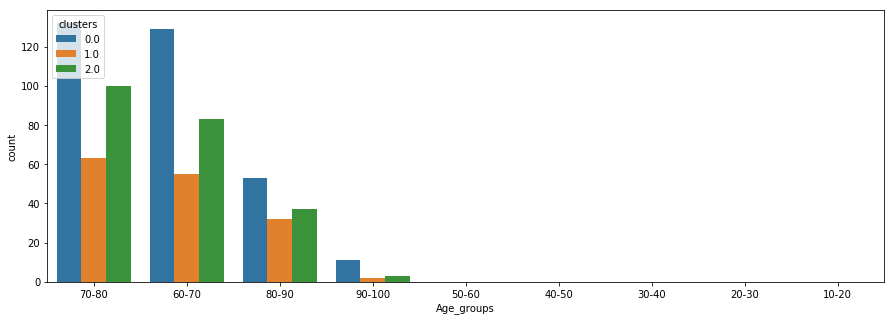

In [24]:
plt.subplots(figsize = (15,5))
sns.countplot(x=final_df2['Age_groups'],order=final_df2['Age_groups'].value_counts().index,hue=final_df2['clusters'])
plt.show()

In [25]:
centroid_df2

,AccessUsingHealthApp,UnderstandOnlineMedRec,UsefulOnlineMedRec
0,-1.0,-1.0,-1.0
1,-2.0,-2.0,-2.0
2,2.0,2.0,1.0


We need to deal with missing values first before doing this analysis